In [90]:
import os
import glob
import numpy as np
import pretty_midi
from collections import defaultdict
import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
import numpy as np
import os

## Data Preprocessing

In [91]:
## Dataset paths
DATASET_DIR = "../Composer_Dataset/NN_midi_files_extended"
OUTPUT_DIR = "./processed_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

splits = ["train", "dev", "test"]

#### Inspect dataset

In [92]:
def inspect_dataset():
    composers = []
    counts = defaultdict(int)
    total_files = 0
    for split in splits:
        split_dir = os.path.join(DATASET_DIR, split)
        for composer in os.listdir(split_dir):
            composer_dir = os.path.join(split_dir, composer)
            if not os.path.isdir(composer_dir):
                continue
            # count the MIDI files per composer
            composers.append(composer)
            n_files = len([f for f in os.listdir(composer_dir) if f.endswith('.mid')])
            counts[composer] += n_files
            total_files += n_files

    composers = sorted(list(set(composers)))
    print(f"Total MIDI files: {total_files}")
    print(f"Composers: {composers}")
    for composer in composers:
        print(f"   - {composer}: {counts[composer]}")

inspect_dataset()

Total MIDI files: 439
Composers: ['bach', 'bartok', 'byrd', 'chopin', 'handel', 'hummel', 'mendelssohn', 'mozart', 'schumann']
   - bach: 50
   - bartok: 49
   - byrd: 50
   - chopin: 49
   - handel: 49
   - hummel: 50
   - mendelssohn: 49
   - mozart: 49
   - schumann: 44


- MIDI File to Note Sequence Extraction

In [93]:
# MIDI to note sequence
def midi_to_note_sequence(midi_file):
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    notes = []
    for instrument in midi_data.instruments:
        if instrument.is_drum: 
            continue
        for note in instrument.notes:
            notes.append((note.start, note.end, note.pitch, note.velocity))
    notes.sort()
    return notes

- create augmented versions of note sequences by shifting all note pitches up or down by a specified number of semitones

In [94]:
# Augment notes 
def augment_notes(notes, transpose=0):
    augmented = []
    for start, end, pitch, vel in notes:
        new_pitch = pitch + transpose
        if 0 <= new_pitch <= 127:  # MIDI valid pitch range
            augmented.append((start, end, new_pitch, vel))
    return augmented

- convert list of MIDI notes into a 2D piano roll matrix

In [95]:
# Piano-roll feature
def extract_piano_roll(notes, time_resolution=0.05, max_time=30.0):
    n_bins = int(max_time / time_resolution)
    piano_roll = np.zeros((n_bins, 128))
    # convert note start/end times into bins in the piano roll
    for start, end, pitch, vel in notes:
        start_bin = int(start / time_resolution)
        end_bin = int(end / time_resolution)
        if start_bin >= n_bins:
            continue
        end_bin = min(end_bin, n_bins - 1)
        piano_roll[start_bin:end_bin+1, pitch] += vel / 127.0
    # Clip values to [0,1]
    piano_roll = np.clip(piano_roll, 0, 1)
    return piano_roll


#### Data Visualization

- generate and display a visual piano roll from a MIDI file

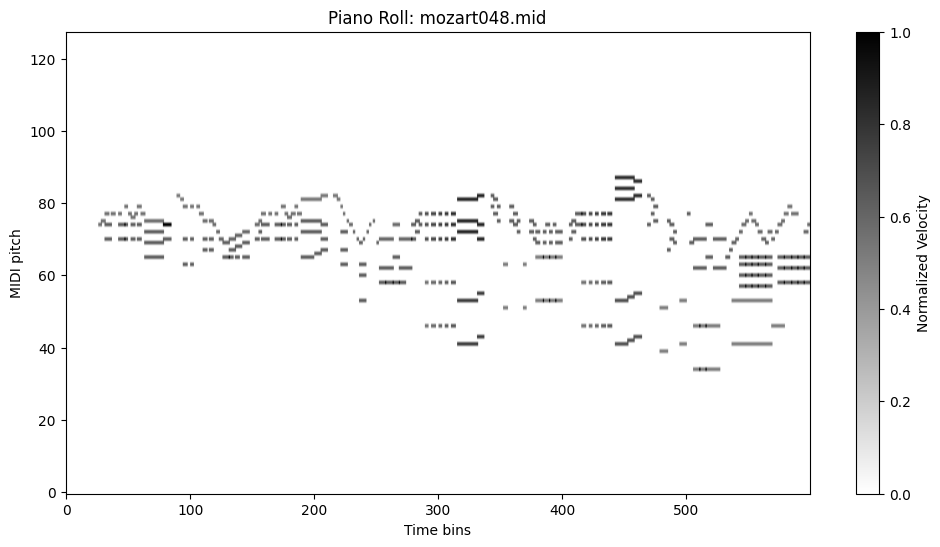

In [96]:
def visualize_piano_roll(midi_file):
    notes = midi_to_note_sequence(midi_file)
    piano_roll = extract_piano_roll(notes)

    plt.figure(figsize=(12, 6))
    plt.imshow(piano_roll.T, aspect='auto', origin='lower', cmap='gray_r')
    plt.colorbar(label='Normalized Velocity')
    plt.title(f"Piano Roll: {os.path.basename(midi_file)}")
    plt.xlabel("Time bins")
    plt.ylabel("MIDI pitch")
    plt.show()
midi_files = glob.glob(os.path.join(DATASET_DIR, 'train', '*', '*.mid'))[0]
visualize_piano_roll(midi_files)

### Feature Extraction & Data Augmentation

- processe each file into deep learning input formats (CNN and LSTM)

In [97]:
def extract_sequence(notes):
    return [pitch for _, _, pitch, _ in notes]
## loop through splits and composers, process MIDI files
for split in splits:
    split_dir = os.path.join(DATASET_DIR, split)
    for composer in os.listdir(split_dir):
        composer_dir = os.path.join(split_dir, composer)
        if not os.path.isdir(composer_dir):
            continue
        files = glob.glob(os.path.join(composer_dir, "*.mid"))
        # process and save original features
        for f in tqdm.tqdm(files, desc=f"{split}/{composer}"):
            base = os.path.basename(f).replace(".mid", "")

            # original
            notes = midi_to_note_sequence(f)
            piano_roll = extract_piano_roll(notes)
            lstm_seq = extract_sequence(notes)

            np.save(os.path.join(OUTPUT_DIR, f"{split}_{composer}_{base}_cnn.npy"), piano_roll)
            np.save(os.path.join(OUTPUT_DIR, f"{split}_{composer}_{base}_lstm.npy"), lstm_seq)

            # data augmentations only on training split
            if split == "train":
                for semitone in [-2, -1, 1, 2]:
                    aug_notes = augment_notes(notes, transpose=semitone)
                    piano_roll_aug = extract_piano_roll(aug_notes)
                    lstm_seq_aug = extract_sequence(aug_notes)

                    aug_base = f"{base}_aug{semitone:+d}"
                    np.save(os.path.join(OUTPUT_DIR, f"{split}_{composer}_{aug_base}_cnn.npy"), piano_roll_aug)
                    np.save(os.path.join(OUTPUT_DIR, f"{split}_{composer}_{aug_base}_lstm.npy"), lstm_seq_aug)

train/mozart:   0%|          | 0/41 [00:00<?, ?it/s]/opt/anaconda3/envs/project_env/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
test/bartok: 100%|██████████| 4/4 [00:00<00:00, 60.12it/s]


## Build Model

#### CNN

#### Load preprocessed CNN data for model train

In [98]:
def load_data(cnn):
    X = []
    y = []
    label_map = {}
    label_counter = 0

    files = glob.glob("./processed_data/train_*_cnn.npy")
    for f in files:
        parts = os.path.basename(f).split("_")
        composer = parts[1]
        if composer not in label_map:
            label_map[composer] = label_counter
            label_counter += 1
        X.append(np.load(f))
        y.append(label_map[composer])

    X = np.array(X)
    y = np.array(y)
    print(f"Loaded {len(X)} samples with shape {X.shape} and {len(label_map)} classes.")
    return X, y, label_map

In [99]:
 
X_cnn, y_cnn, label_map = load_data("cnn")
X_cnn = X_cnn[..., np.newaxis]

X_train, X_val, y_train, y_val = train_test_split(
    X_cnn, y_cnn, test_size=0.2, stratify=y_cnn, random_state=42
)


Loaded 1845 samples with shape (1845, 600, 128) and 9 classes.


#### Build CNN Model

In [100]:

def build_cnn(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

cnn_model = build_cnn(
    input_shape=X_train.shape[1:], num_classes=len(label_map)
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 600, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 300, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 300, 64, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 150, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 307200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │     9,830,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,849,545 (37.57 MB)

 Trainable params: 9,849,545 (37.57 MB)

 Non-trainable params: 0 (0.00 B)

#### Train CNN Model

In [101]:

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

cnn_history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 293ms/step - accuracy: 0.1845 - loss: 2.1136 - val_accuracy: 0.3713 - val_loss: 1.8203
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 284ms/step - accuracy: 0.3314 - loss: 1.7424 - val_accuracy: 0.5068 - val_loss: 1.5532
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 285ms/step - accuracy: 0.4631 - loss: 1.4779 - val_accuracy: 0.6287 - val_loss: 1.2899
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 285ms/step - accuracy: 0.5212 - loss: 1.2282 - val_accuracy: 0.7371 - val_loss: 1.0370
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 286ms/step - accuracy: 0.6369 - loss: 1.0719 - val_accuracy: 0.8022 - val_loss: 0.9005
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 287ms/step - accuracy: 0.6682 - loss: 0.9319 - val_accuracy: 0.8293 - val_loss: 0.7641
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 285ms/step - accuracy: 0.6929 - loss: 0.8209 - val_accuracy: 0.8618 - val_loss: 0.6566
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 286ms/step - accuracy: 0.7326 - loss: 0.7619 - val_accu

#### Evaluate CNN Model 

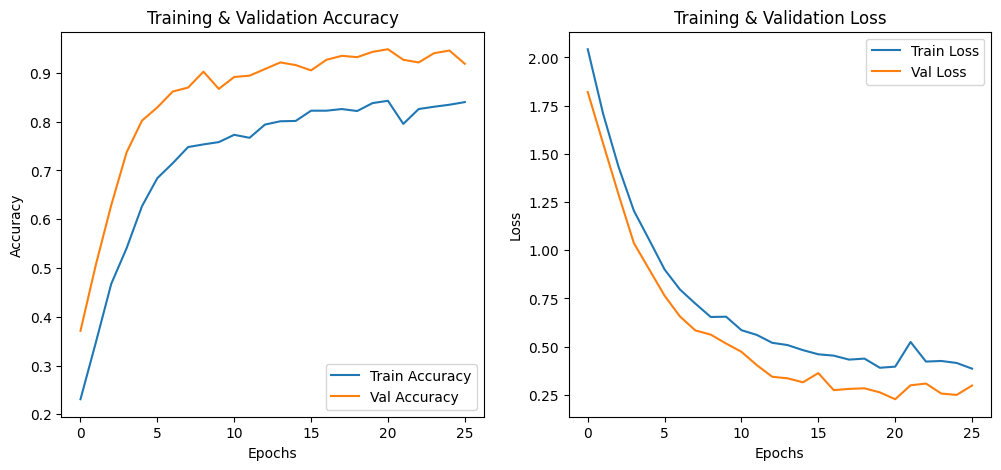

In [102]:
def plot_training_curves(history):
    # Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.show()
plot_training_curves(cnn_history)

In [103]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
y_pred_probs = cnn_model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy * 100:.3f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Accuracy: 94.851%


In [105]:

# y_true = np.argmax(y_val, axis=1)
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=label_map.keys()))

Classification Report:
              precision    recall  f1-score   support

 mendelssohn       1.00      0.83      0.91        41
      chopin       0.95      0.93      0.94        41
    schumann       0.86      0.95      0.90        38
        bach       1.00      0.98      0.99        42
        byrd       1.00      0.98      0.99        42
      hummel       0.98      1.00      0.99        42
      handel       0.86      0.93      0.89        41
      bartok       0.98      0.98      0.98        41
      mozart       0.93      0.98      0.95        41

    accuracy                           0.95       369
   macro avg       0.95      0.95      0.95       369
weighted avg       0.95      0.95      0.95       369



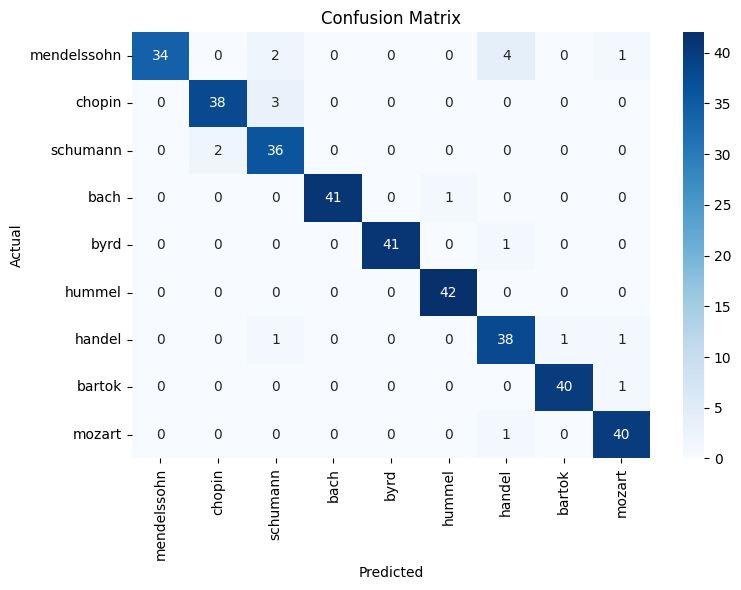

In [106]:
cm = confusion_matrix(y_val, y_pred)
composer_names = list(label_map.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=composer_names, yticklabels=composer_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

### LSTM Model

#### Load preprocessed data 

In [142]:
def load_data_lstm():
    X = []
    y = []
    label_map = {}
    label_counter = 0

    files = glob.glob(f"./processed_data/train_*_lstm.npy")
    for f in files:
        parts = os.path.basename(f).split("_")
        composer = parts[1]
        if composer not in label_map:
            label_map[composer] = label_counter
            label_counter += 1
        X.append(np.load(f, allow_pickle=True))  # allow_pickle since it’s a list
        y.append(label_map[composer])

    y = np.array(y)
    print(f"Loaded {len(X)} LSTM samples with {len(label_map)} classes.")
    return X, y, label_map

X_lstm_raw, y_lstm, label_map = load_data_lstm()

Loaded 1845 LSTM samples with 9 classes.


- analyze sequence length below which 95% of the data falls

In [143]:
# Check sequence lengths
lengths = [len(seq) for seq in X_lstm_raw]
print(f"95th percentile sequence length: {np.percentile(lengths, 95)}")

95th percentile sequence length: 14738.0


- Pad shorter sequences with zeros at the end
- Truncate longer sequences from the end

In [144]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 100

def prepare_lstm_data(sequences, maxlen):
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
    return np.array(padded)
X_lstm = prepare_lstm_data(X_lstm_raw, maxlen)

- Split data into train and validation

In [145]:
# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_lstm, y_lstm, test_size=0.2, stratify=y_lstm
)

#### Define LSTM Model

In [146]:
def build_lstm(input_length, num_classes):

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_length,)),
        tf.keras.layers.Embedding(
            input_dim=128,      # MIDI pitches range from 0–127
            output_dim=64,
            input_length=input_length
        ),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

lstm_model = build_lstm(input_length=X_train.shape[1], num_classes=len(label_map))



/opt/anaconda3/envs/project_env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 100, 64)        │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,161 (629.54 KB)

 Trainable params: 161,161 (629.54 KB)

 Non-trainable params: 0 (0.00 B)

#### Train LSTM Model

In [147]:
# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.0887 - loss: 2.1978 - val_accuracy: 0.1545 - val_loss: 2.2568
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.1666 - loss: 2.1869 - val_accuracy: 0.1843 - val_loss: 2.1566
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.1707 - loss: 2.1476 - val_accuracy: 0.1734 - val_loss: 2.1717
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.2181 - loss: 2.0820 - val_accuracy: 0.1978 - val_loss: 2.1165
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2135 - loss: 2.0511 - val_accuracy: 0.2087 - val_loss: 2.1270
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.1896 - loss: 2.0432 - val_accuracy: 0.2168 - val_loss: 2.0601
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2206 - loss: 2.0409 - val_accuracy: 0.2304 - val_loss: 2.0554
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.2719 - loss: 1.9554 - val_accuracy: 0.2033 - v

#### Evaluate LSTM Model 

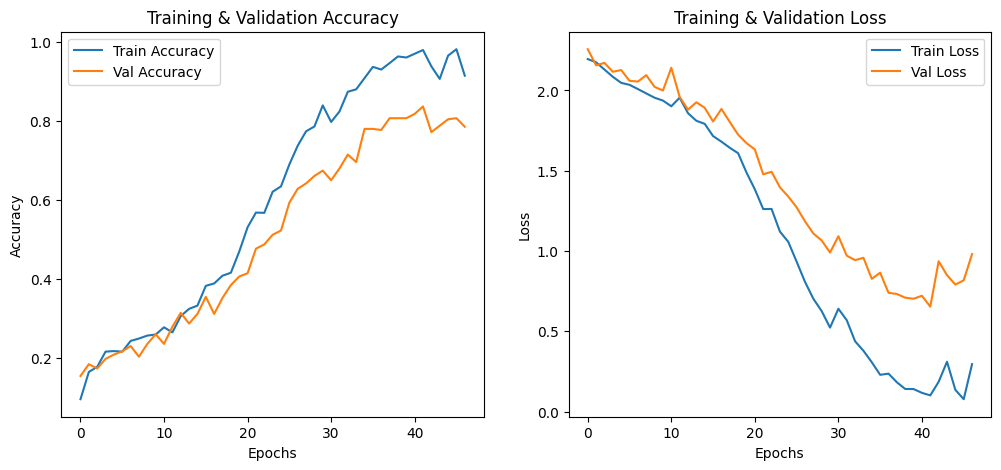

In [148]:
def plot_training_curves(history):
    # Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
    plt.plot(lstm_history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(lstm_history.history['loss'], label='Train Loss')
    plt.plot(lstm_history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.show()
plot_training_curves(lstm_history)

In [149]:
y_pred_probs_lstm = lstm_model.predict(X_val)
y_pred_lstm = np.argmax(y_pred_probs_lstm, axis=1)

acc = accuracy_score(y_val, y_pred_lstm)
print(f"\nAccuracy: {acc * 100:.3}%")


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Accuracy: 83.7%


In [150]:
print("Classification Report:")
print(classification_report(y_val, y_pred_lstm, target_names=label_map.keys()))


Classification Report:
              precision    recall  f1-score   support

      chopin       0.80      0.78      0.79        41
      bartok       0.82      0.90      0.86        41
        bach       0.84      0.90      0.87        42
      mozart       0.78      0.61      0.68        41
      handel       0.88      0.93      0.90        41
 mendelssohn       0.79      0.80      0.80        41
        byrd       0.91      0.93      0.92        42
      hummel       0.84      0.88      0.86        42
    schumann       0.86      0.79      0.82        38

    accuracy                           0.84       369
   macro avg       0.84      0.84      0.83       369
weighted avg       0.84      0.84      0.83       369



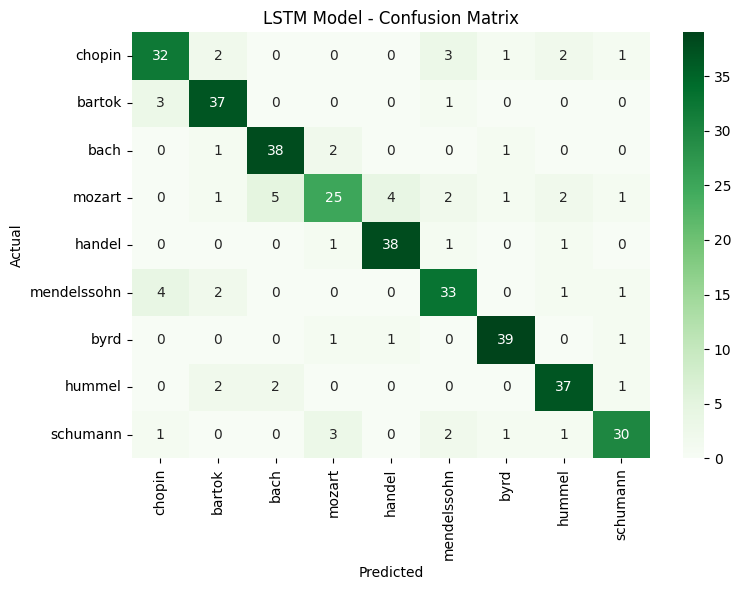

In [151]:
cm = confusion_matrix(y_val, y_pred_lstm)
composer_names = list(label_map.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=composer_names, yticklabels=composer_names, cmap='Greens')
plt.title("LSTM Model - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()